In [1]:
import datetime

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from data import example_to_tensor
from train import EarlyStopping
from utils import plot_slice, plot_animated_volume

print(f"Tensorflow: {tf.__version__}")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

Tensorflow: 2.3.0


In [9]:
verbose_training = True
# Hyperparameters
epochs = 1000
learning_rate = 0.0001
patience = 5
batch_size = 2
test_size = 1
validation_size = 1
xy_size = 128  # downscale 4
z_size = 96  # downscale 4 (nrrd)
#z_size = 244  # downscale 4 (tcia)
# xy_size = 256  # downscale 2
# z_size = 176  # downscale 2
# xy_size = 512   # original
# z_size = 368    # original

In [3]:
dtype = "float32"
dataset = tf.data.TFRecordDataset(f"data/nrrd-0.25-{dtype}.tfrecords")
dataset = dataset.map(lambda x: example_to_tensor(x, dtype))
dataset = dataset.padded_batch(
    batch_size=2, padded_shapes=[z_size, xy_size, xy_size, 1],
)
test_dataset = dataset.take(test_size)
dataset = dataset.skip(test_size)
val_dataset = dataset.take(validation_size)
train_dataset = dataset.skip(validation_size)
train_dataset = train_dataset.shuffle(buffer_size=10, reshuffle_each_iteration=True)
train_dataset

<ShuffleDataset shapes: (None, 96, 128, 128, 1), types: tf.float32>

In [4]:
encoder = keras.models.Sequential(
    [
        keras.layers.Conv3D(
            input_shape=[z_size, xy_size, xy_size, 1],
            filters=8,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.MaxPool3D(pool_size=2),
        keras.layers.Conv3D(
            filters=16,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.MaxPool3D(pool_size=2),
    ]
)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 96, 128, 128, 8)   224       
_________________________________________________________________
activation (Activation)      (None, 96, 128, 128, 8)   0         
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 96, 128, 128, 8)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 48, 64, 64, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 48, 64, 64, 16)    3472      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 64, 64, 16)    0         
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 48, 64, 64, 16)    0

In [5]:
decoder = keras.models.Sequential(
    [
        keras.layers.UpSampling3D(
            input_shape=encoder.layers[-1].output.shape[1:], size=2,
        ),
        keras.layers.Conv3D(
            filters=16,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.UpSampling3D(size=2,),
        keras.layers.Conv3D(
            filters=8,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.Dense(1),
        keras.layers.Activation("sigmoid"),
    ]
)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling3d (UpSampling3D) (None, 48, 64, 64, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 48, 64, 64, 16)    6928      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 64, 64, 16)    0         
_________________________________________________________________
alpha_dropout_2 (AlphaDropou (None, 48, 64, 64, 16)    0         
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 96, 128, 128, 16)  0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 96, 128, 128, 8)   3464      
_________________________________________________________________
activation_3 (Activation)    (None, 96, 128, 128, 8)  

In [6]:
autoencoder = keras.models.Sequential([encoder, decoder])
# autoencoder.load_weights("models/autoencoder/20200723-103317/best_epoch_ckpt")
# autoencoder = keras.models.load_model("models/autoencoder/20200823-110737/")
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 24, 32, 32, 16)    3696      
_________________________________________________________________
sequential_1 (Sequential)    (None, 96, 128, 128, 1)   10401     
Total params: 14,097
Trainable params: 14,097
Non-trainable params: 0
_________________________________________________________________


In [7]:
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(lr=learning_rate)

In [8]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"logs/autoencoder/{current_time}/"
model_dir = f"models/autoencoder/{current_time}/"
ckpt_dir = model_dir + "best_epoch_ckpt"
writer = tf.summary.create_file_writer(log_dir)
early_stopping = EarlyStopping(patience)

for epoch in tqdm(range(epochs), disable=False):
    
    ### TRAIN ###
    
    train_loss_metric = tf.keras.metrics.Mean("train_loss", dtype=tf.float32)
    for batch in train_dataset:
        with tf.GradientTape() as tape:
            predictions = autoencoder(batch)
            loss_value = loss_fn(predictions, batch)
        gradients = tape.gradient(loss_value, autoencoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
        train_loss_metric.update_state(loss_value)
        #with writer.as_default():
        #    for grad, param in zip(gradients, autoencoder.trainable_variables):
        #        tf.summary.histogram(param.name, param, step=epoch)
        #        # tf.summary.histogram(param.name + "/grad", grad, buckets=1, step=epoch)

    train_loss_mean = train_loss_metric.result()
    with writer.as_default():
        tf.summary.scalar("Training loss", train_loss_mean, step=epoch)
    train_loss_metric.reset_states()
   
   ### VALIDATION ###

    val_loss_metric = tf.keras.metrics.Mean("val_loss", dtype=tf.float32)
    for batch in val_dataset:
        predictions = autoencoder(batch)
        val_loss_metric.update_state(loss_fn(predictions, batch))

    val_loss_mean = val_loss_metric.result()
    with writer.as_default():
        tf.summary.scalar("Validation loss", val_loss_mean, step=epoch)
    val_loss_metric.reset_states()

    if verbose_training:
        print()
        print(f"Epoch : {epoch}")
        print(f"Training loss: {train_loss_mean}")
        print(f"Validation loss: {val_loss_mean}")
    
    ### EARLY STOPPING ###
    
    early_stopping.update(val_loss_mean)
    if early_stopping.early_stop:
        autoencoder.load_weights(ckpt_dir)
        break
    elif early_stopping.not_improving_epochs == 0:
        autoencoder.save_weights(ckpt_dir)

autoencoder.save(model_dir)

with writer.as_default():
    tf.summary.text(
        "Hyperparameters",
        f"batch size = {batch_size}; "
        f"patience = {patience}; "
        f"learning rate = {learning_rate}",
        step=0,
    )


Epoch : 0
Training loss: 0.1594489961862564
Validation loss: 0.012903683818876743

Epoch : 1
Training loss: 0.009840529412031174
Validation loss: 0.011816131882369518

Epoch : 2
Training loss: 0.009128519333899021
Validation loss: 0.011571250855922699

Epoch : 3
Training loss: 0.008879613131284714
Validation loss: 0.011387853883206844

Epoch : 4
Training loss: 0.008676431141793728
Validation loss: 0.011230646632611752

Epoch : 5
Training loss: 0.008501803502440453
Validation loss: 0.011088207364082336

Epoch : 6
Training loss: 0.008348383940756321
Validation loss: 0.010953349061310291

Epoch : 7
Training loss: 0.008204793557524681
Validation loss: 0.01081518828868866

Epoch : 8
Training loss: 0.00805483665317297
Validation loss: 0.010637848637998104

Epoch : 9
Training loss: 0.007848801091313362
Validation loss: 0.010335758328437805

Epoch : 10
Training loss: 0.00743182934820652
Validation loss: 0.009469998069107533

Epoch : 11
Training loss: 0.005850012879818678
Validation loss: 0.00


Epoch : 95
Training loss: 0.0007474799058400095
Validation loss: 0.0007771996897645295

Epoch : 96
Training loss: 0.0007460069027729332
Validation loss: 0.0007725488394498825

Epoch : 97
Training loss: 0.0007417758461087942
Validation loss: 0.0007694140658713877

Epoch : 98
Training loss: 0.000738481932785362
Validation loss: 0.0007660796400159597

Epoch : 99
Training loss: 0.0007346548372879624
Validation loss: 0.0007635367219336331

Epoch : 100
Training loss: 0.0007323595345951617
Validation loss: 0.000761855102609843

Epoch : 101
Training loss: 0.0007302393205463886
Validation loss: 0.0007575571071356535

Epoch : 102
Training loss: 0.0007255046512000263
Validation loss: 0.0007559804362244904

Epoch : 103
Training loss: 0.0007223301217891276
Validation loss: 0.0007522337255068123

Epoch : 104
Training loss: 0.0007213849457912147
Validation loss: 0.0007485246169380844

Epoch : 105
Training loss: 0.0007168145384639502
Validation loss: 0.0007459267508238554

Epoch : 106
Training loss: 

In [10]:
%reload_ext tensorboard
%tensorboard --logdir=logs --bind_all

Reusing TensorBoard on port 6006 (pid 159635), started 3:59:50 ago. (Use '!kill 159635' to kill it.)

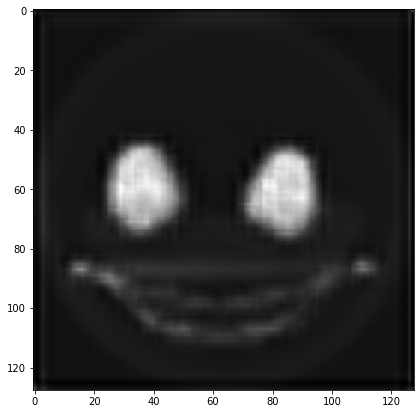

In [11]:
scan = next(iter(dataset))
prediction = autoencoder(scan)
plot_slice(prediction, 0, 5)

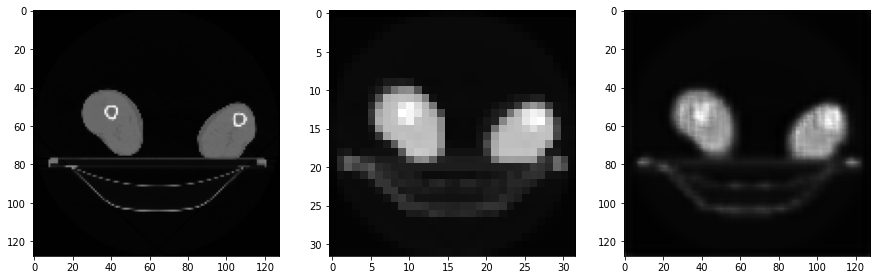

In [15]:
encoder_input = next(iter(test_dataset))
fig, ax = plt.subplots(ncols=3)
batch_index = 0
z_index = 30
plot_slice(encoder_input, batch_index, z_index, ax[0])
encoder_out = autoencoder.layers[0](encoder_input)
plot_slice(encoder_out, batch_index, encoder_out.shape[1] // 3, ax[1])
decoder_out = autoencoder.layers[1](encoder_out)
plot_slice(decoder_out, batch_index, z_index, ax[2])
#ax[0].imshow(tf.cast(i[sample, 0, :, :, 0], tf.float32), cmap="gray")
#encoder_out = autoencoder.layers[0](i)
#ax[1].imshow(tf.cast(encoder_out[sample, 0, :, :, 0], tf.float32), cmap="gray")
#decoder_out = autoencoder.layers[1](encoder_out)
#ax[2].imshow(tf.cast(decoder_out[sample, 0, :, :, 0], tf.float32), cmap="gray")